In [17]:
import cv2
from pytube import YouTube
from IPython.display import display, Image, Audio, Video
from dotenv import load_dotenv
import base64
import time
import os
import requests
import openai

In [2]:
OUTPUT_DIR = 'data/'

In [3]:
load_dotenv()

True

In [4]:
def download_youtube_video(url, save_dir):
    yt = YouTube(url)
    output_path = yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first().download(save_dir)
    return output_path

In [7]:
messi_video_path = download_youtube_video('https://www.youtube.com/watch?v=nEE2ZWwmqBc&ab_channel=Theguywiththelockface', OUTPUT_DIR)

In [8]:
Video(messi_video_path)

In [9]:
video = cv2.VideoCapture(messi_video_path)

base64Frames = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()
print(len(base64Frames), "frames read.")

550 frames read.


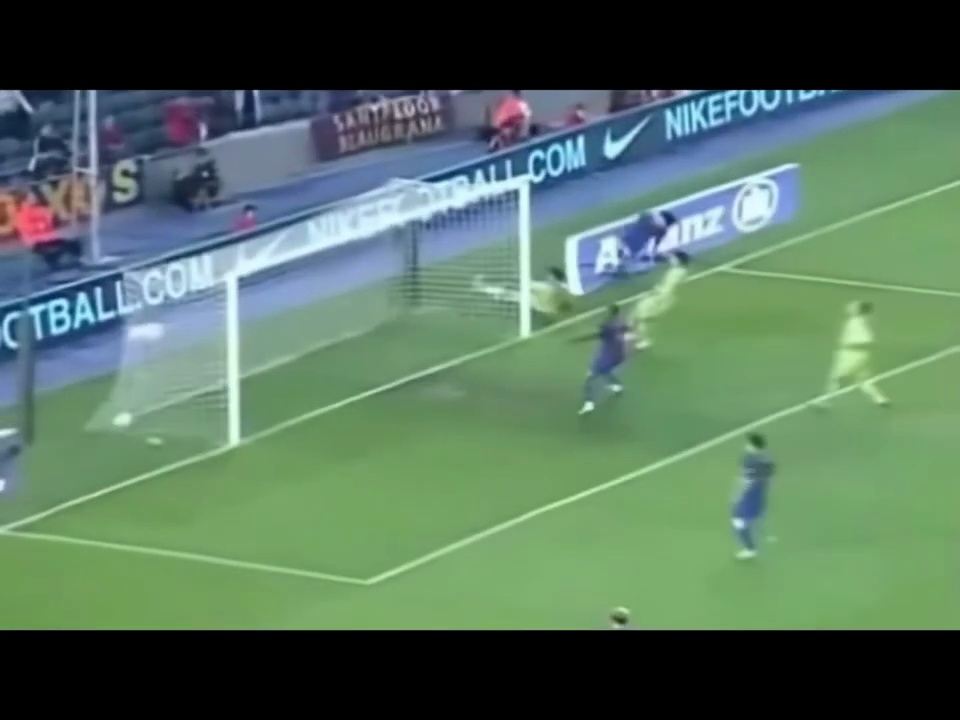

In [31]:
display_handle = display(None, display_id=True)
for img in base64Frames[300:400]:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    time.sleep(0.025)

In [21]:
openai_api_key = os.getenv("OPENAI_KEY")

In [39]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames of a video. Create a short voiceover script in the style of a super excited Japanese sports narrator who is narrating his favorite match. Use caps and exclamation marks where needed to communicate excitement. Only include the narration, your output must be in Japanese. When the ball goes into the net, you must scream GOL either once or multiple times.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::50]),
        ],
    },
]

params = {
    "model": "gpt-4-vision-preview",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 500,
}

client = openai.AsyncOpenAI(api_key=openai_api_key)
result = await client.chat.completions.create(**params)
print(result.choices[0].message.content)


すごいプレッシャーがかかっているぞ！！ 今、彼らは圧倒的な攻撃を見せつけている！センターサークルを抜け、ドリブルを始めた！なんというスピードだ！ディフェンダーが何人も寄ってくるが、どんどん抜き去る！これは見事なテクニックだ！まるで舞っているかのようなドリブル！！彼の前にはもう誰もいない！シュート！！！GOL！GOL！GOL！！！信じられないゴールだ！！！このスタジアムが熱狂に包まれている！！！


In [44]:
response = requests.post(
    "https://api.openai.com/v1/audio/speech",
    headers={
        "Authorization": f"Bearer {openai_api_key}",
    },
    json={
        "model": "tts-1",
        "input": result.choices[0].message.content,
        "voice": "fable",
    },
)

audio = b""
for chunk in response.iter_content(chunk_size=1024 * 1024):
    audio += chunk
Audio(audio)

In [46]:
with open(f'{OUTPUT_DIR}output.mp3', 'wb') as file:
    file.write(audio)

print("The MP3 file has been saved locally as 'output.mp3'.")

The MP3 file has been saved locally as 'output.mp3'.
